# **1) Proje Özeti ve Hedef**

Bu projede PlantVillage görüntüleri üzerinde, sıfırdan tasarlanmış bir Custom CNN ile bitki hastalığı sınıflandırması yapıyorum. Veri ön işleme, veri artırma
(augmentation), eğitim stratejisi (early stopping, LR azaltma, model checkpoint), değerlendirme (accuracy, macro/weighted F1), TTA (test-time augmentation), Eigen-CAM görselleştirmeleri ve çıktıların diske kaydı yer alıyor.

In [2]:
!pip install -q split-folders grad-cam==1.5.0

import os, sys, json, random, shutil, glob, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from collections import defaultdict
import seaborn as sns
import cv2
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score
)
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from collections import Counter
import matplotlib.pyplot as plt
import time
import os

print("TF:", tf.__version__)
physical_gpus = tf.config.list_physical_devices('GPU')
print("GPU:", physical_gpus)
if physical_gpus:
    for g in physical_gpus:
        tf.config.experimental.set_memory_growth(g, True)

SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Yol ayarları
KAGGLE_INPUT_ROOT = "/kaggle/input"
WORK_ROOT = "/kaggle/working"
PROJECT_ROOT = os.path.join(WORK_ROOT, "plant_disease_project")
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports")
GRADCAM_DIR = os.path.join(REPORTS_DIR, "gradcam")
SPLIT_OUT = os.path.join(WORK_ROOT, "plant_data_split")
os.makedirs(GRADCAM_DIR, exist_ok=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# PlantVillage veri setini indir (Kaggle ortamı için)
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


# **Veri Kökünü Otomatik Bulma ve Train/Val/Test Bölme**

Bu bölüm PlantVillage klasör kökünü bulur ve veri henüz bölünmemişse %80/%10/%10 oranıyla train/val/test olarak ayırır.

In [4]:
# Veri kökünü bul
def find_plantvillage_root():
    candidates = []
    for root, dirs, files in os.walk(KAGGLE_INPUT_ROOT):
        if len(dirs) >= 10 and any("Tomato___" in d or "Potato___" in d or "Pepper__" in d for d in dirs):
            candidates.append(root)
    if candidates:
        return sorted(candidates, key=lambda p: len(p))[0]
    return None

RAW_ROOT = find_plantvillage_root()
# Bölünmüş veri yoksa oluştur
if not os.path.exists(os.path.join(SPLIT_OUT, "train")):
    splitfolders.ratio(
        RAW_ROOT, output=SPLIT_OUT, seed=SEED, ratio=(.8, .1, .1)
    )

for part in ["train","val","test"]:
    p = os.path.join(SPLIT_OUT, part)
    n_imgs = sum(len(files) for _,_,files in os.walk(p))
    n_classes = len(next(os.walk(p))[1])
    print(part, "images:", n_imgs, "classes:", n_classes)


Copying files: 20639 files [02:04, 165.37 files/s]

train images: 16505 classes: 15
val images: 2058 classes: 15
test images: 2076 classes: 15


# **Sınıf Dağılımlarını İnceleme**

Sınıf başına örnek sayısını çıkarır ve görselleştiririz. Bu, dengesizlik olup olmadığını hızlıca anlamamıza yardım eder.

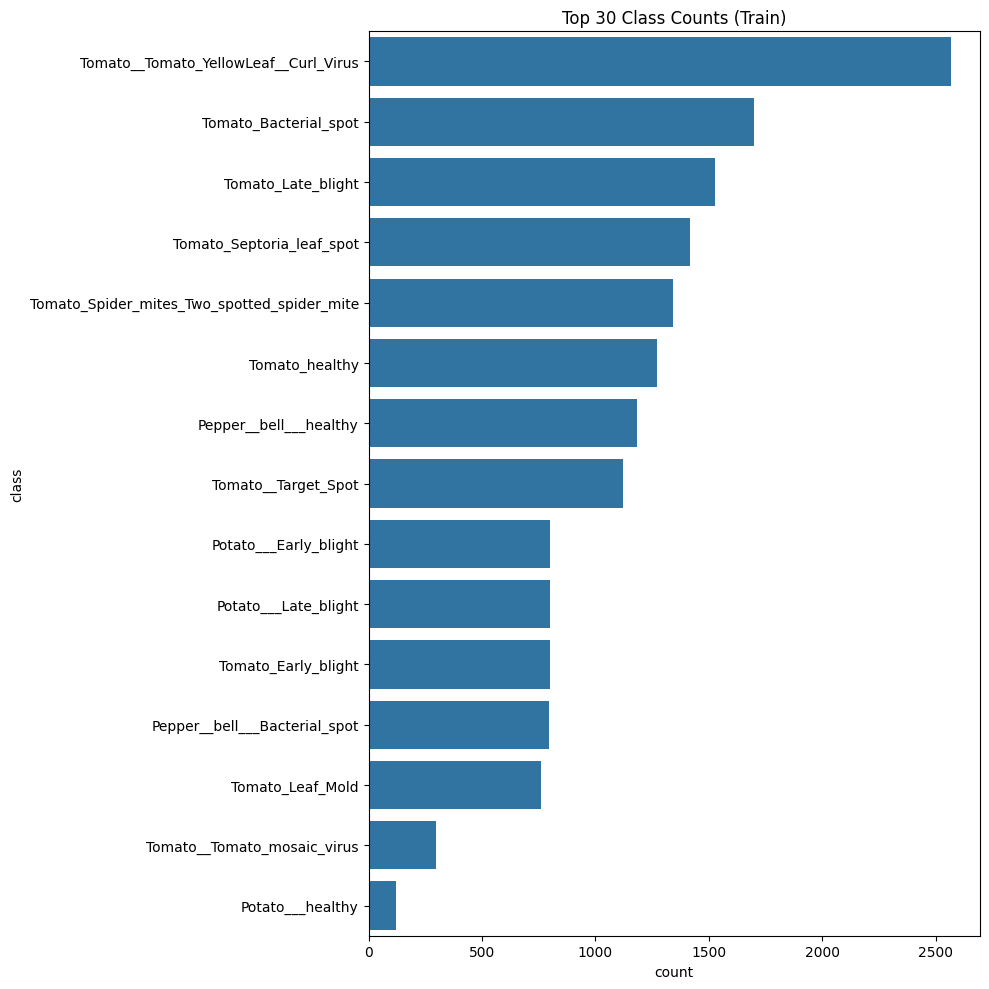

(15,
 ['Pepper__bell___Bacterial_spot',
  'Pepper__bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_Leaf_Mold',
  'Tomato_Septoria_leaf_spot'])

In [5]:
#  Sınıf dağılımlarını say
train_dir = os.path.join(SPLIT_OUT, "train")
classes = sorted(next(os.walk(train_dir))[1])
class_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in classes}
df_counts = pd.DataFrame({"class": list(class_counts.keys()), "count": list(class_counts.values())}).sort_values("count", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(data=df_counts.head(30), y="class", x="count")
plt.title("Top 30 Class Counts (Train)")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, "class_counts.png"))
plt.show()

len(classes), classes[:10]

# **Data Augmentation**

Eğitim sırasında daha iyi genelleme için veri artırma(data augmentation) uygularız. Doğrulama ve test setlerinde yalnızca yeniden ölçekleme yapılır.

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(SPLIT_OUT, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_OUT, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_OUT, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
CLASS_INDICES = {v:k for k,v in train_gen.class_indices.items()}
CLASS_INDICES | dict(list(CLASS_INDICES.items())[:5])


num_classes = len(train_gen.class_indices)
print("Sınıf sayısı:", num_classes)



Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.
Sınıf sayısı: 15


# **Hiperparametre optimizasyonu**

In [7]:
import math
from tensorflow import keras
from tensorflow.keras import layers

def build_model(num_classes, lr):
    model = keras.Sequential([
        layers.Input(shape=(224,224,3)),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

learning_rates = [1e-4, 3e-4, 1e-3]
batch_sizes    = [16, 32, 64]
EPOCHS         = 5  # hızlı deneme için
results = {}

for lr in learning_rates:
    for bs in batch_sizes:
        # --- generator'ları bu batch size ile yeniden kur ---
        train_gen_bs = train_datagen.flow_from_directory(
            os.path.join(SPLIT_OUT, "train"),
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=bs,
            class_mode="categorical",
            shuffle=True,
            seed=SEED
        )
        val_gen_bs = val_test_datagen.flow_from_directory(
            os.path.join(SPLIT_OUT, "val"),
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=bs,
            class_mode="categorical",
            shuffle=False
        )

        model = build_model(num_classes, lr)

        steps_per_epoch   = math.ceil(train_gen_bs.samples / bs)
        validation_steps  = math.ceil(val_gen_bs.samples / bs)

        hist = model.fit(
            train_gen_bs,
            epochs=EPOCHS,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_gen_bs,
            validation_steps=validation_steps,
            verbose=0
        )
        val_acc = hist.history['val_accuracy'][-1]
        results[f'lr={lr}_bs={bs}'] = val_acc
        print(f'lr={lr}, bs={bs} -> val_acc={val_acc:.4f}')

print("Hiperparametre sonuçları:")
for k,v in results.items():
    print(f"{k}: {v:.4f}")


Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0001, bs=16 -> val_acc=0.2779
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0001, bs=32 -> val_acc=0.2259
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0001, bs=64 -> val_acc=0.1900
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0003, bs=16 -> val_acc=0.4466
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0003, bs=32 -> val_acc=0.3178
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.0003, bs=64 -> val_acc=0.3095
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.001, bs=16 -> val_acc=0.5258
Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
lr=0.001, bs=32 -> val_acc=0.4427
Found 16504 images belongi

#**Artırılmış Görüntü Örnekleri**

Bir batch içerisinden örnek görselleri ve etiketlerini görselleştirerek artırmanın doğru çalıştığını kontrol ederiz.

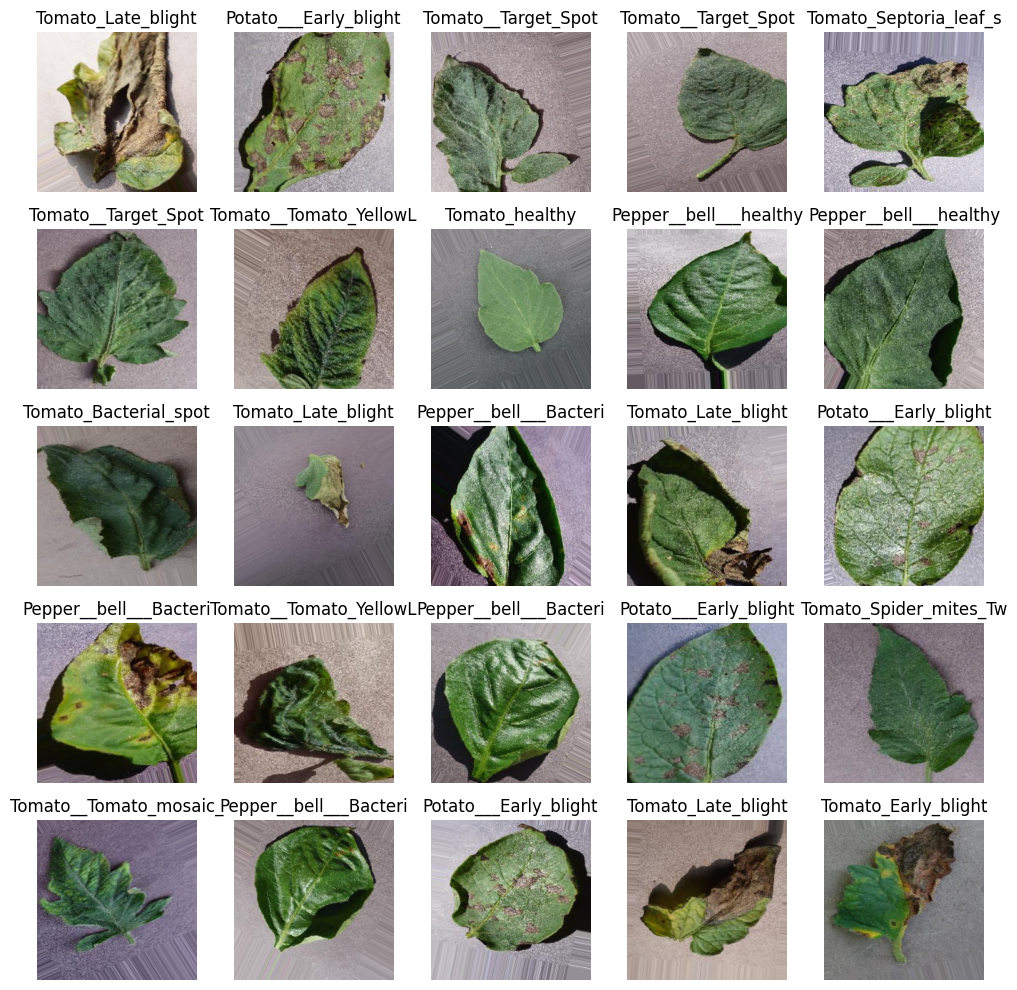

In [8]:
x_batch, y_batch = next(train_gen)

idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_batch[i])
    plt.axis("off")
    label_idx = y_batch[i].argmax()
    plt.title(idx_to_class[label_idx][:22])
plt.tight_layout()
plt.show()


idx_to_class = {v: k for k, v in train_gen.class_indices.items()}



#**Train/Val/Test Sınıf Dağılımı Karşılaştırması**

Üç parçadaki dağılımları hızlıca karşılaştırırız.

Train sınıf sayısı: 15
Val   sınıf sayısı: 15
Test  sınıf sayısı: 15


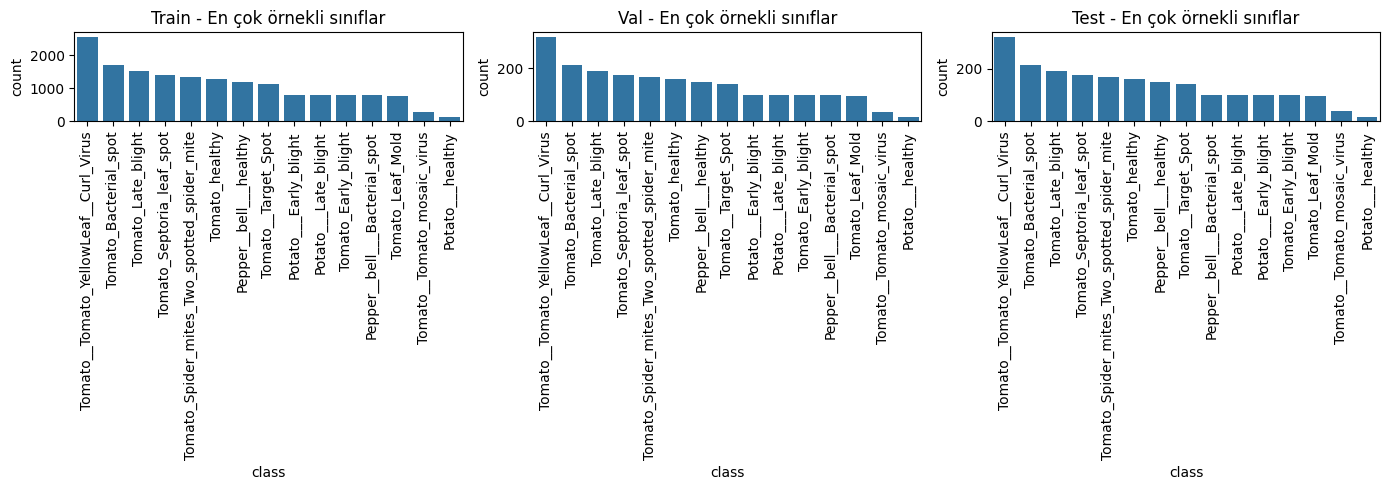

In [ ]:
def class_counts_from_gen(gen):
    # gen.classes: her örnek için sınıf indeksi
    counts = Counter(gen.classes.tolist())
    df = pd.DataFrame({
        "class_idx": list(counts.keys()),
        "count": list(counts.values())
    })
    df["class"] = df["class_idx"].map(idx_to_class)
    return df.sort_values("count", ascending=False).reset_index(drop=True)

df_train = class_counts_from_gen(train_gen)
df_val   = class_counts_from_gen(val_gen)
df_test  = class_counts_from_gen(test_gen)

print("Train sınıf sayısı:", df_train["class"].nunique())
print("Val   sınıf sayısı:", df_val["class"].nunique())
print("Test  sınıf sayısı:", df_test["class"].nunique())

top_k = 20
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.barplot(x="class", y="count", data=df_train.head(top_k))
plt.title("Train - En çok örnekli sınıflar"); plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.barplot(x="class", y="count", data=df_val.head(top_k))
plt.title("Val - En çok örnekli sınıflar"); plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.barplot(x="class", y="count", data=df_test.head(top_k))
plt.title("Test - En çok örnekli sınıflar"); plt.xticks(rotation=90)

plt.tight_layout(); plt.show()

# **5) CNN Mimari (Bitki Hastalıklarının Sınıflandırılması için Evrişimsel Sinir Ağı)**
Bu bölümde, bitki hastalıklarını sınıflandırmak için tasarladığım PlantDiseaseModel ( create_cnn_model()) mimarisini tanıtıyor olacağım. Model, üç evrişim bloğunda (her blokta iki Conv2D katmanı) öznitelikleri kademeli olarak çıkarır; ardından tam bağlı katmanlarla sınıf olasılıklarını üretir.

**Architecture Overview**

Girdi ve Normalizasyon: Model, veri üreteçlerinden gelen (IMG_H, IMG_W, 3) boyutlu ve rescale=1./255 ile ölçeklenmiş görüntüleri alır; çıktı boyutu NUM_CLASSES’tır (sınıf sayısı üreteçten otomatik alınır).

**Evrişim Blokları (3 blok):**

**Blok 1:** Conv2D(32)** → BatchNorm → Conv2D(32) → MaxPool(2×2) → Dropout(0.2)

**Blok 2:** Conv2D(64) → BatchNorm → Conv2D(64) → MaxPool(2×2) → Dropout(0.3)

**Blok 3:** Conv2D(128) → BatchNorm → Conv2D(128) → MaxPool(2×2) → Dropout(0.4)

Her blokta padding='same' ve ReLU aktivasyonu kullanılır. Filtre sayıları (32→64→128) katman derinleştikçe artırılarak daha karmaşık desenlerin yakalanması sağlanır. Batch Normalization eğitim stabilitesini artırır, MaxPooling uzamsal boyutu azaltır, Dropout ise aşırı uyumu (overfitting) sınırlar.

**Sınıflandırıcı Başlık:**

Flatten → Dense(128, ReLU) → BatchNorm → Dropout(0.5) → Dense(NUM_CLASSES, Softmax)
Flatten, uzamsal öznitelik haritalarını vektöre dönüştürerek 128 nöronlu bir gizli katmana aktarır. Son katmandaki Softmax, her sınıf için olasılık üretir.

**Neden bu mimari?**

**Denge ve Basitlik:** Üç bloklu yapı, PlantVillage gibi veri setleri için yeterli kapasite sunarken gereksiz karmaşıklıktan kaçınır.

**Düzenli Öğrenme:** BatchNorm + Dropout kombinasyonu, daha hızlı yakınsama ve daha iyi genelleme sağlar.

**Öznitelik Zenginliği:** Her blokta iki Conv2D kullanımı, aynı çözünürlük seviyesinde daha zengin temsil öğrenilmesine yardımcı olur.

**Uygulama Dostu:** NUM_CLASSES ve girdi boyutları üreteçlerden otomatik alındığı için farklı veri kümelerine kolayca uyarlanır.

# 1) Veri tarafı

In [ ]:
NUM_CLASSES = train_gen.num_classes
IMG_H, IMG_W, _ = train_gen.image_shape

def create_cnn_model():
    return keras.Sequential([
        # İlk blok
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_H, IMG_W, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # İkinci blok
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Üçüncü blok
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Sınıflandırıcı
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')  # 10 sabitini kaldırdık
    ])

cnn_model = create_cnn_model()
cnn_model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,135,535 (50.11 MB)

 Trainable params: 13,134,831 (50.11 MB)

 Non-trainable params: 704 (2.75 KB)

# 2) Derleme

In [ ]:

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


"\noptimizer='adam': Adaptif öğrenme oranı ile hızlı ve genelde sağlam yakınsama.\n\nloss='categorical_crossentropy': Çok sınıflı ve one-hot etiketli problemlerde doğru kayıp fonksiyonu.\n\nmetrics=['accuracy']: Eğitimi ve doğrulamayı izlerken doğruluk metriğini raporlar"

**optimizer='adam'**: Adaptif öğrenme oranı ile hızlı ve genelde sağlam yakınsama.

**loss='categorical_crossentropy'**: Çok sınıflı ve one-hot etiketli problemlerde doğru kayıp fonksiyonu.

**metrics=['accuracy']**: Eğitimi ve doğrulamayı izlerken doğruluk metriğini raporlar

# 3) Callback’ler


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

**monitor**='val_loss': Doğrulama kaybını izler.

**patience=8**: 8 epoch boyunca iyileşme olmazsa eğitim durdurulur.

**restore_best_weights=True**: Eğitim bitince en düşük doğrulama kaybına sahip ağırlıklara geri dönülür (overfitting’i azaltır).

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

Doğrulama kaybı 3 epoch boyunca iyileşmezse, öğrenme oranını 0.2 katsayısıyla düşürür.

**min_lr**=1e-5 altına düşmez; böylece “çok küçük LR” sorunlarına karşı taban sınır koyar.

**Amaç**: Plato’da kalan eğitimi daha küçük adımlarla ilerletmek.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best.keras',
    monitor='val_loss',
    save_best_only=True
)

Eğitim boyunca en iyi (en düşük val_loss) ağırlıkları best.keras dosyasına kaydeder.

**save_best_only=True**: Sadece iyileşme olduğunda yazdığı için disk israfını önler.


# 4) Eğitim (generator ile)


In [ ]:
start_time = time.time()

history = cnn_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} sn")

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 253s 465ms/step - accuracy: 0.5157 - loss: 1.5766 - val_accuracy: 0.4830 - val_loss: 1.7750 - learning_rate: 0.0010
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 238s 461ms/step - accuracy: 0.7527 - loss: 0.7700 - val_accuracy: 0.7012 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 233s 451ms/step - accuracy: 0.8139 - loss: 0.5655 - val_accuracy: 0.7483 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 265s 457ms/step - accuracy: 0.8494 - loss: 0.4742 - val_accuracy: 0.8494 - val_loss: 0.5138 - learning_rate: 0.0010
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 230s 446ms/step - accuracy: 0.8742 - loss: 0.3886 - val_accuracy: 0.8154 - val_loss: 0.7042 - learning_rate: 0.0010
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 229s 444ms/step - accuracy: 0.8939 - loss: 0.3340 - val_accuracy: 0.6749 - val_loss: 1.9049 - learning_rate: 0.0010
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 230s 445ms/step - accura

**train_gen**: Veri artırma (augmentation) ve yeniden ölçekleme uygulayan eğitim üreteci.

**validation_data=val_gen**: Her epoch sonunda doğrulama seti üzerinde ölçüm yapılır.

**callbacks**: Üç callback beraber çalışır; aşırı uyumu frenler, LR’ı düşürür, en iyi ağırlıkları saklar.

**history**: Eğitim/Doğrulama loss ve accuracy kayıtlarını içerir (grafik için kullanıyoruz).

**training_time**: Toplam süreyi ölçüp yazdırır.


# 5) En iyi modeli yükleyip test değerlendirme


In [ ]:
best_model = keras.models.load_model('best.keras')
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9448 - loss: 0.1553
Test Loss: 0.1944 | Test Acc: 0.9383


# 6) Öğrenme eğrileri


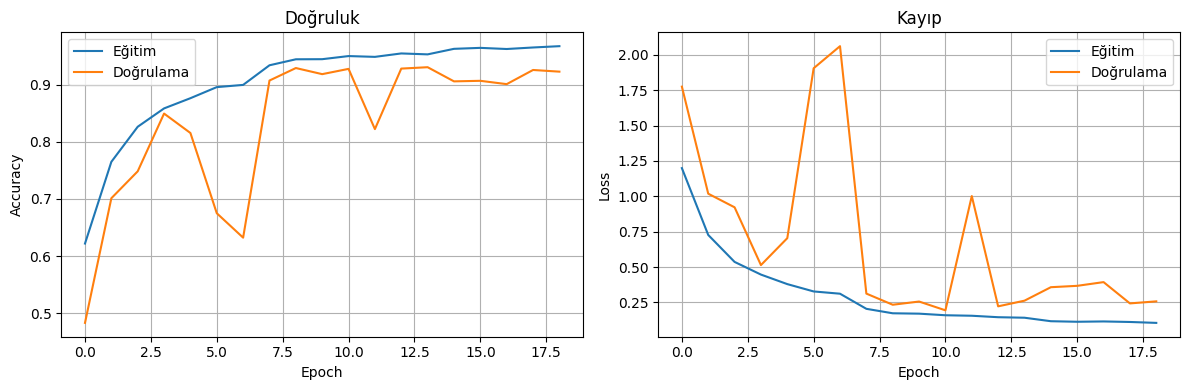

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.title('Doğruluk'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim')
plt.plot(history.history['val_loss'], label='Doğrulama')
plt.title('Kayıp'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

#**Bitki Türüne Göre Performans Analizi**

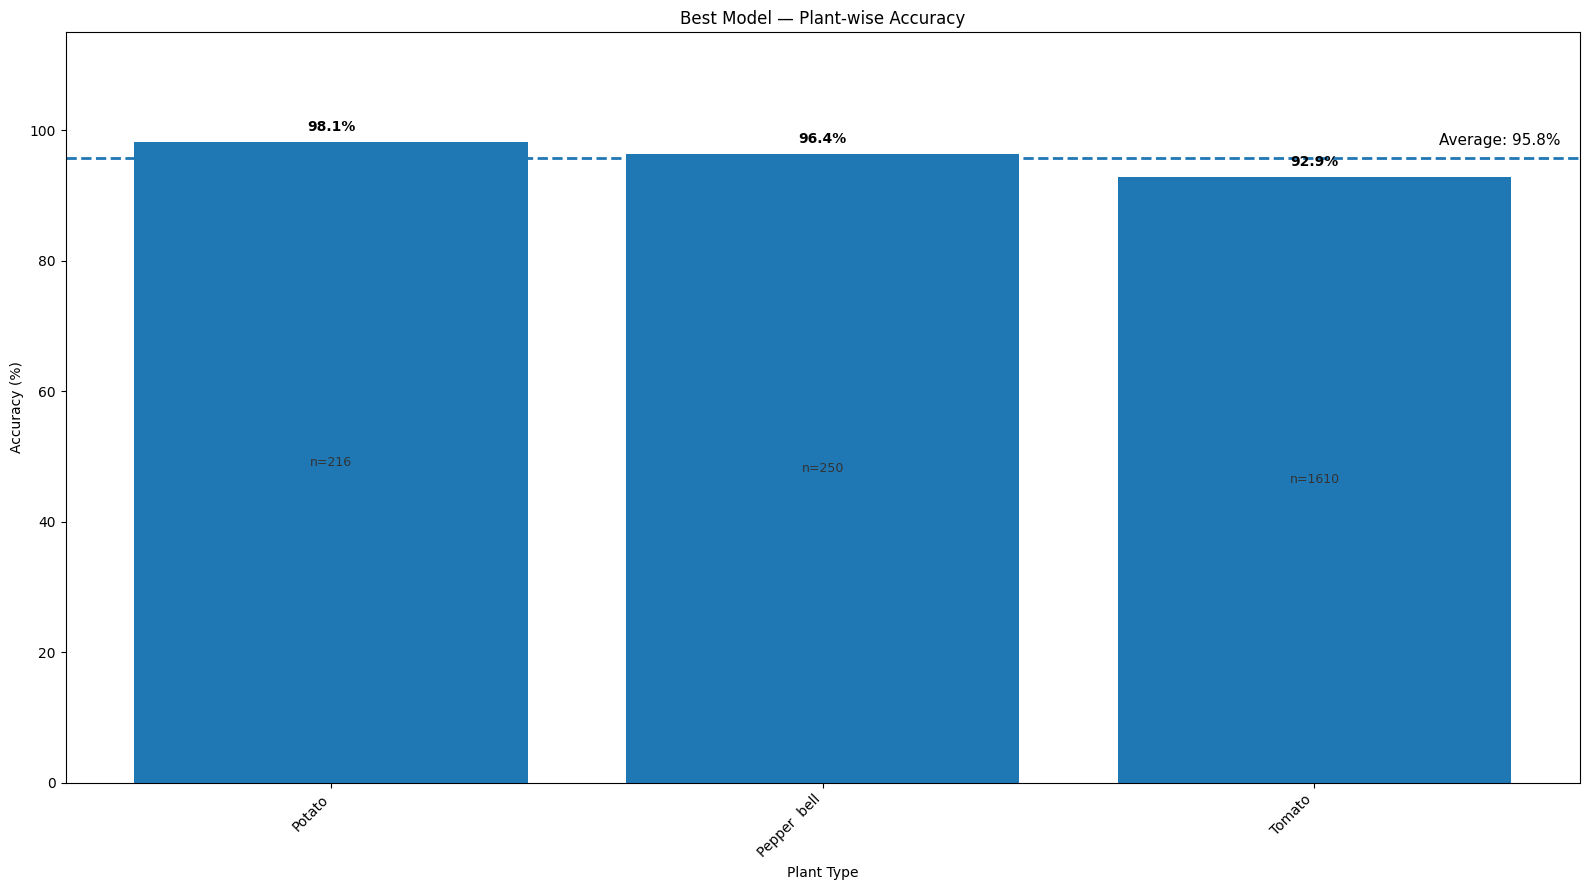

Top performer: Potato (98.1%) — n=216
Potato         :  98.1%
Pepper  bell   :  96.4%
Tomato         :  92.9%


In [ ]:
def parse_plant_name(class_name: str) -> str:
    """
    'Tomato___Late_blight' -> 'Tomato'
    'Pepper__bell___Bacterial_spot' -> 'Pepper' (her ihtimale karşı)
    'Apple_scab' -> 'Apple' (altçizgiye göre ilk parça)
    """
    if "___" in class_name:
        plant = class_name.split("___")[0]
    elif "__" in class_name:
        plant = class_name.split("__")[0]
    else:
        plant = class_name.split("_")[0]
    return plant.replace("_", " ").strip()

def evaluate_by_plant_type_tf(model,
                              gen,
                              tta: int = 0,
                              title: str = None,
                              save_png: str = None):
    """
    model: Keras modeli
    gen:   Keras DirectoryIterator (val_gen / test_gen)
    tta:   Test-Time Augmentation tekrar sayısı
    title: Grafik başlığı
    save_png: Kaydetmek için dosya yolu

    Dönüş: {'Tomato': 95.1, 'Potato': 92.3, ...}  (yüzde)
    """
    # 1) Gerçek etiketler ve sınıf isimleri
    y_true = gen.classes.astype(int)
    idx_to_class = {v: k for k, v in gen.class_indices.items()}

    # 2) Tahminler
    def _predict_once():
        gen.reset()
        probs = model.predict(gen, verbose=0)
        return probs.argmax(axis=1)

    if tta and tta > 0:
        preds_list = []
        for _ in range(tta):
            preds_list.append(_predict_once())
        y_pred = np.rint(np.mean(np.stack(preds_list, axis=0), axis=0)).astype(int)  # çoğunluk/ortalama
    else:
        y_pred = _predict_once()

    # 3) Bitki türüne indirgeme
    plant_correct = defaultdict(int)
    plant_total   = defaultdict(int)

    for i in range(len(y_true)):
        true_idx = y_true[i]
        true_class = idx_to_class[true_idx]
        plant = parse_plant_name(true_class)
        plant_total[plant] += 1
        if y_pred[i] == true_idx:
            plant_correct[plant] += 1

    # 4) Yüzdeler
    plant_accuracy = {p: (plant_correct[p] / plant_total[p]) * 100.0
                      for p in plant_total.keys()}

    # 5) Görselleştirme
    plants = sorted(plant_accuracy.keys(), key=lambda p: plant_accuracy[p], reverse=True)
    accs   = [plant_accuracy[p] for p in plants]
    counts = [plant_total[p] for p in plants]
    avg_acc = np.mean(accs) if accs else 0.0

    plt.figure(figsize=(16, 9))
    bars = plt.bar(plants, accs)

    # çubuk anotasyonları
    for bar, acc, n in zip(bars, accs, counts):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 1.2,
                 f"{acc:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")
        plt.text(bar.get_x() + bar.get_width()/2, max(h*0.5, 2),
                 f"n={n}", ha="center", va="center", fontsize=9, color="#333")

    # ortalama çizgisi
    plt.axhline(avg_acc, linewidth=2, linestyle="--")
    plt.text(len(plants)-0.5, avg_acc + 1.5,
             f"Average: {avg_acc:.1f}%", ha="right", va="bottom", fontsize=11)

    plt.ylim(0, max(accs + [100]) * 1.15 if accs else 1)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Plant Type")
    plt.title(title or f"Model Accuracy by Plant Type ({getattr(model, 'name', 'model')})")
    plt.tight_layout()

    if save_png:
        plt.savefig(save_png, dpi=150, bbox_inches="tight")
    plt.show()

    # En iyi başarım bilgisi
    if plants:
        print(f"Top performer: {plants[0]} ({plant_accuracy[plants[0]]:.1f}%) — n={plant_total[plants[0]]}")
    return plant_accuracy


plant_acc = evaluate_by_plant_type_tf(
    model=best_model,
    gen=test_gen,
    tta=0,
    title="Best Model — Plant-wise Accuracy",
    save_png="plant_type_accuracy.png"
)

# Sonuç sözlüğü:
for k, v in sorted(plant_acc.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{k:15s}: {v:5.1f}%")


#**Multiclass metrics & confusion matrix**

Overall Accuracy : 0.9383
Macro Precision  : 0.9399 | Macro Recall : 0.9343 | Macro F1 : 0.9352
Weighted Precision: 0.9425 | Weighted Recall: 0.9383 | Weighted F1: 0.9386

Per-class classification report:


,precision,recall,f1-score,support
Pepper__bell___Bacterial_spot,0.9892,0.9109,0.9485,101.0000
Pepper__bell___healthy,0.9868,1.0000,0.9933,149.0000
Potato___Early_blight,0.9519,0.9900,0.9706,100.0000
Potato___Late_blight,0.8235,0.9800,0.8950,100.0000
Potato___healthy,1.0000,0.9375,0.9677,16.0000
Tomato_Bacterial_spot,0.9722,0.9813,0.9767,214.0000
Tomato_Early_blight,0.9072,0.8800,0.8934,100.0000
Tomato_Late_blight,0.9763,0.8594,0.9141,192.0000
Tomato_Leaf_Mold,1.0000,0.8854,0.9392,96.0000
Tomato_Septoria_leaf_spot,0.8860,0.9607,0.9218,178.0000


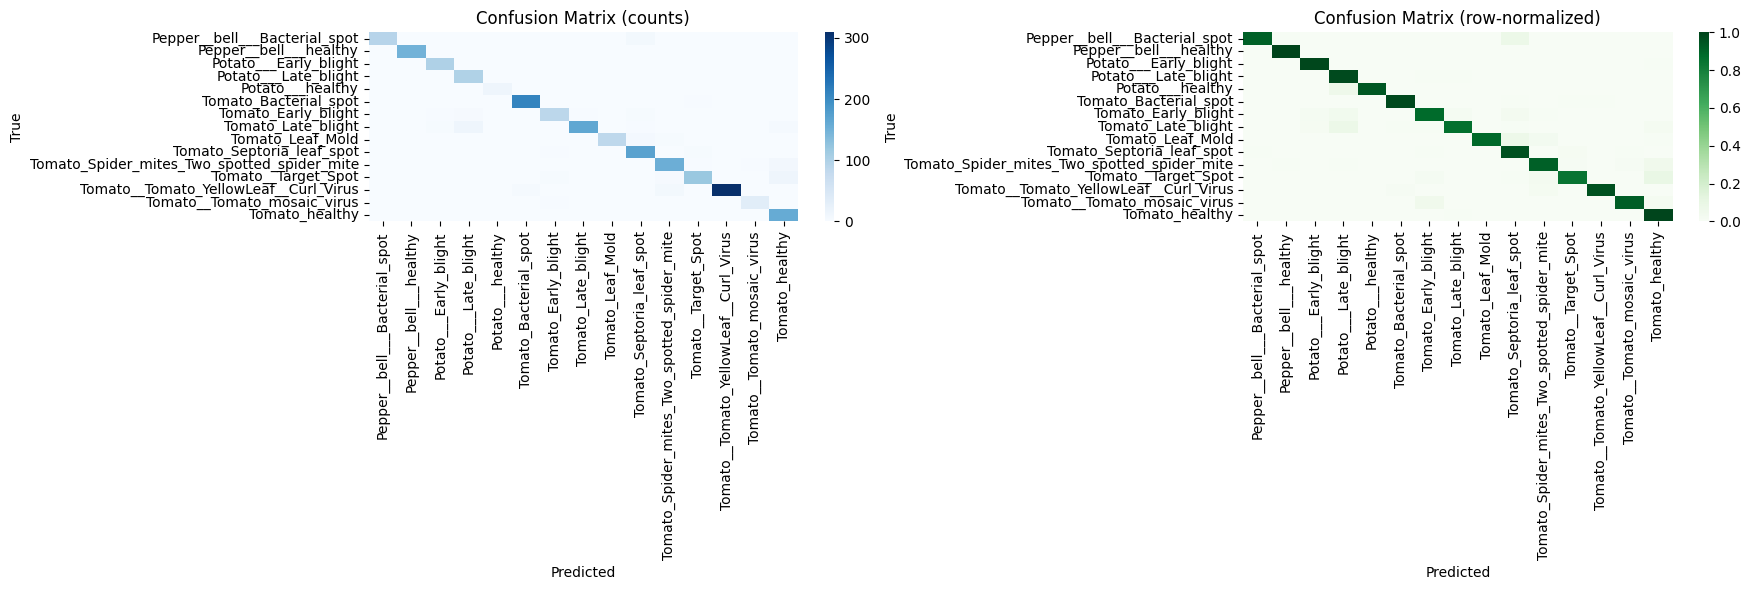


Top-10 most confused pairs (true → predicted):
Tomato__Target_Spot                 → Tomato_healthy                      | count=  14 | frac=0.099
Pepper__bell___Bacterial_spot       → Tomato_Septoria_leaf_spot           | count=   8 | frac=0.079
Tomato_Late_blight                  → Potato___Late_blight                | count=  15 | frac=0.078
Tomato_Leaf_Mold                    → Tomato_Septoria_leaf_spot           | count=   7 | frac=0.073
Potato___healthy                    → Potato___Late_blight                | count=   1 | frac=0.062
Tomato_Spider_mites_Two_spotted_spider_mite → Tomato_healthy                      | count=   9 | frac=0.053
Tomato__Tomato_mosaic_virus         → Tomato_Early_blight                 | count=   2 | frac=0.053
Tomato_Early_blight                 → Potato___Late_blight                | count=   4 | frac=0.040
Tomato_Leaf_Mold                    → Tomato_Spider_mites_Two_spotted_spider_mite | count=   3 | frac=0.031
Tomato_Early_blight                 

In [ ]:
# 1) Gerçek etiketler ve sınıf isimleri
y_true = test_gen.classes.astype(int)
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 2) Tahminler
test_gen.reset()
y_prob = best_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# 3) Özet metrikler
acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

print(f"Overall Accuracy : {acc:.4f}")
print(f"Macro Precision  : {prec_macro:.4f} | Macro Recall : {rec_macro:.4f} | Macro F1 : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_weighted:.4f} | Weighted Recall: {rec_weighted:.4f} | Weighted F1: {f1_weighted:.4f}")

# 4) Class bazlı rapor
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
display_cols = ["precision", "recall", "f1-score", "support"]
report_df = report_df[display_cols].round(4)
print("\nPer-class classification report:")
display(report_df)

# 5) Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].tick_params(axis='x', rotation=90)

sns.heatmap(cm_norm, annot=False, cmap="Greens",
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout(); plt.show()

# 6) En çok karışan ilk 10 sınıf çifti
pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, :].sum() > 0:
            pairs.append((class_names[i], class_names[j], cm[i, j], cm_norm[i, j]))
pairs_sorted = sorted(pairs, key=lambda x: x[3], reverse=True)[:10]

print("\nTop-10 most confused pairs (true → predicted):")
for t, p, cnt, frac in pairs_sorted:
    print(f"{t:35s} → {p:35s} | count={cnt:4d} | frac={frac:0.3f}")


#**Eigen CAM**

In [ ]:
def list_conv_layers(model):
    print("== Top-level layers ==")
    for i, L in enumerate(model.layers):
        try:
            _ = L.output
            out = getattr(L, 'output_shape', 'OK')
        except Exception:
            out = "NO-OUTPUT (not connected)"
        print(f"{i:02d} | {L.name:<30} | {L.__class__.__name__:<22} | {out}")

    print("\n== Nested layers ==")
    for P in model.layers:
        if isinstance(P, keras.Model):
            print(f"\n[ Parent: {P.name} ]")
            for j, L in enumerate(P.layers):
                try:
                    _ = L.output
                    out = getattr(L, 'output_shape', 'OK')
                except Exception:
                    out = "NO-OUTPUT (not connected)"
                print(f"  {j:02d} | {L.name:<30} | {L.__class__.__name__:<22} | {out}")

list_conv_layers(best_model)


== Top-level layers ==
00 | conv2d_18                      | Conv2D                 | OK
01 | batch_normalization_12         | BatchNormalization     | OK
02 | conv2d_19                      | Conv2D                 | OK
03 | max_pooling2d_9                | MaxPooling2D           | OK
04 | dropout_12                     | Dropout                | OK
05 | conv2d_20                      | Conv2D                 | OK
06 | batch_normalization_13         | BatchNormalization     | OK
07 | conv2d_21                      | Conv2D                 | OK
08 | max_pooling2d_10               | MaxPooling2D           | OK
09 | dropout_13                     | Dropout                | OK
10 | conv2d_22                      | Conv2D                 | OK
11 | batch_normalization_14         | BatchNormalization     | OK
12 | conv2d_23                      | Conv2D                 | OK
13 | max_pooling2d_11               | MaxPooling2D           | OK
14 | dropout_14                     | Dropout        

In [ ]:
def eigen_cam(model, img_bgr, target_size=(224,224), conv_layer_name=None, normalize=True):
    """
    model            : Keras modeli (tf.keras.Model)
    img_bgr          : OpenCV BGR görüntü (np.uint8), tek görüntü
    target_size      : modele girecek boyut (W,H)
    conv_layer_name  : CAM için kullanılacak conv katmanı adı (None ise son conv bulunur)
    normalize        : ısı haritasını 0-255 ölçeğine getir

    return: heatmap_gray(uint8), overlay_bgr(uint8)
    """
    img_resized = cv2.resize(img_bgr, target_size)
    x = img_resized.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)
    x = x[..., ::-1]  # BGR -> RGB

    if conv_layer_name is None:
        conv_layer = None
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:  # (None,H,W,C)
                conv_layer = layer
                break
        if conv_layer is None:
            raise ValueError("Conv katmanı bulunamadı; conv_layer_name verin.")
    else:
        conv_layer = model.get_layer(conv_layer_name)

    feat_model = tf.keras.Model(inputs=model.inputs, outputs=conv_layer.output)

    fmap = feat_model(x).numpy()[0]        # (H,W,C)
    H, W, C = fmap.shape

    X = fmap.reshape((-1, C))              # (N, C) N = H*W
    X = X - X.mean(axis=0, keepdims=True)

    Cov = (X.T @ X) / max(1, (X.shape[0]-1))   # (C,C)
    eigvals, eigvecs = np.linalg.eigh(Cov)     # simetrik -> eigh
    v1 = eigvecs[:, -1]                        # en büyük özdeğere karşılık gelen vektör (C,)

    cam = (fmap * v1).sum(axis=-1)             # (H,W)

    cam = np.maximum(cam, 0)
    if normalize:
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        heatmap = (cam * 255).astype(np.uint8)
    else:
        heatmap = cam

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR renkli ısı haritası
    overlay = cv2.addWeighted(cv2.resize(img_bgr, (W, H)), 0.5, heatmap_color, 0.5, 0)

    return heatmap, overlay


Seçilen tek resim: /kaggle/working/plant_data_split/val/Potato___healthy/8b2ce6b6-f00a-4f25-ac6d-4249dd7dc5f6___RS_HL 1890.JPG


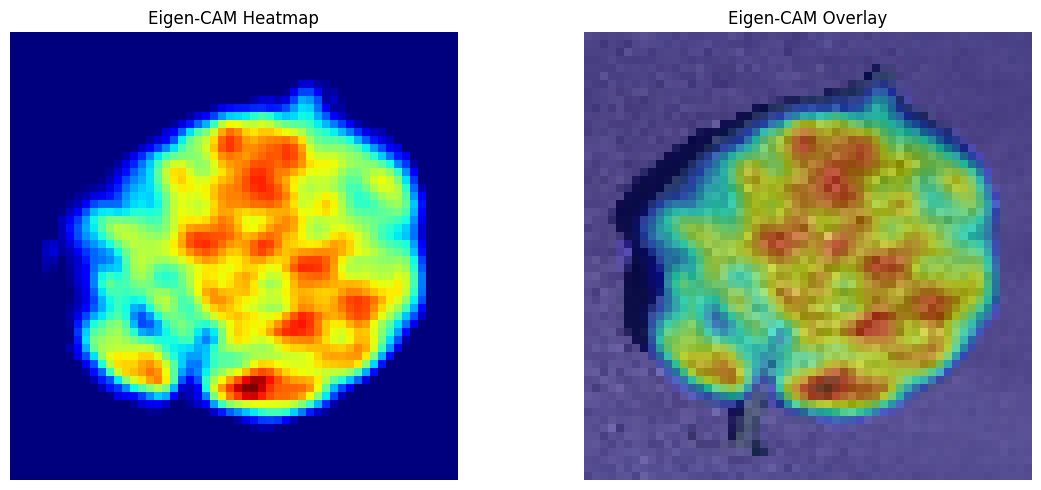

In [ ]:

def pick_one_image(split_root):

    split = "val"
    base = Path(split_root) / split
    class_dirs = [p for p in base.iterdir() if p.is_dir()]
    assert class_dirs, f"{base} içinde sınıf klasörü yok!"
    rng = np.random.default_rng(SEED)
    chosen_class = rng.choice(class_dirs)
    imgs = [p for p in chosen_class.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png"]]
    assert imgs, f"{chosen_class} içinde resim yok!"
    return str(rng.choice(imgs))

img_path = pick_one_image(SPLIT_OUT)
print("Seçilen tek resim:", img_path)

img_bgr = cv2.imread(img_path)
assert img_bgr is not None, f"Görsel okunamadı: {img_path}"

heatmap, overlay = eigen_cam(best_model, img_bgr, target_size=(224,224), conv_layer_name="conv2d_23")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(heatmap, cmap="jet")
plt.title("Eigen-CAM Heatmap")
plt.axis("off")

# Overlay
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Eigen-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()